# CelebA Semantic Loss Model
#### Research Project - Diego Becerra Merodio 5459117
In this Jupyter Notebook, we will train a Semantic Loss model with task of recognizing the different features labeled by the CelebA dataset. This dataset takes images of celebrities and identifies 40 different attributes from their facial features. Using the following image, we identified the correlation between the attributes and derived the predicates for the Semantic Loss model.

<img src="images/CelebA_correlation.png" alt="CelebA Sample" width="600"/>

The first step is to declare and import all dependencies

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from semantic_loss_pytorch import SemanticLoss
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch import optim
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset

After this, we can defined our custom data set for a semisupervised CelebA data set and a model for our neural network

In [13]:
# === Dataset ===
class SemiSupervisedCelebA(Dataset):
    def __init__(self, dataset, labeled_ratio=0.1):
        self.dataset = dataset

        # Get subset indices
        subset_indices = dataset.indices
        full_attrs = dataset.dataset.attr.clone()  # shape: [N, 40]

        # Only use attributes for the subset
        self.attrs = full_attrs[subset_indices]
        self.attrs[self.attrs == -1] = 0

        # Create label mask
        self.labeled_mask = torch.zeros(len(self.attrs), dtype=torch.bool)
        labeled_count = int(len(self.attrs) * labeled_ratio)
        labeled_indices = torch.randperm(len(self.attrs))[:labeled_count]
        self.labeled_mask[labeled_indices] = True

        # Mask unlabeled attributes by setting to -1
        self.attrs[~self.labeled_mask] = -1

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        label = self.attrs[idx]  # shape: [40], with values 0, 1, or -1
        has_label = self.labeled_mask[idx]
        return image, label, has_label

# === Model ===
class CelebANet(nn.Module):
    def __init__(self, num_attrs=40):
        super(CelebANet, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*64*3, 512),
            nn.ReLU(),
            nn.Linear(512, num_attrs),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

Afterwards, we can declare our hyperparameters for the model and load and preprocess our data to be ready to use with the model we have previously declared.

In [14]:
# === Hyperparameters ===
BATCH_SIZE = 64
EPOCHS = 5
NUM_ATTRS = 40
TEST_SIZE = 0.2
SL_WEIGHT = 0.3
LABELED_RATIO = 0.02
LR = 0.001

# === Load CelebA ===
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to manageable size
    transforms.ToTensor()
])

full_dataset = CelebA(root='./data', target_type='attr', download=False, transform=transform)

# === Split into Train and Validation Sets ===
train_idx, val_idx = train_test_split(
    range(len(full_dataset)),
    test_size=TEST_SIZE,
    stratify=full_dataset.attr[:, 20])

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
semi_supervised_dataset = SemiSupervisedCelebA(train_dataset, LABELED_RATIO)

train_loader = DataLoader(semi_supervised_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Here is a simple visualization of our data set

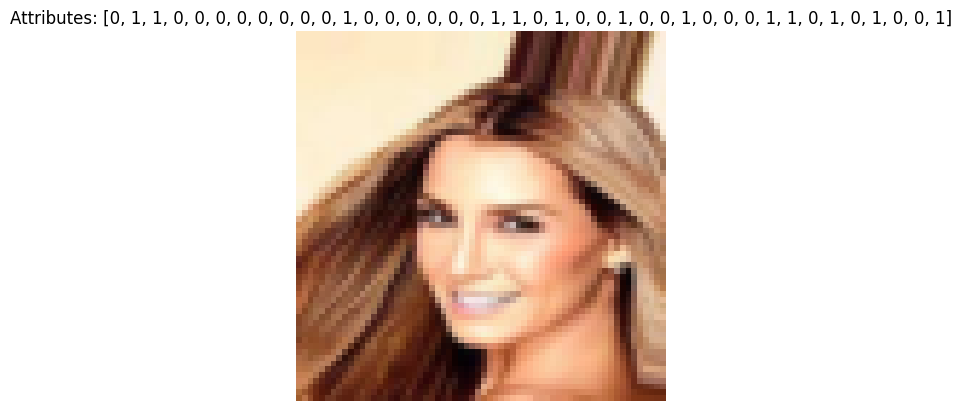

In [15]:
# Visualize a sample
img, attr = full_dataset[0]
plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.title(f"Attributes: {attr[:40].tolist()}")  # Show a few
plt.axis('off')
plt.show()

After this we can define our model

In [17]:
model = CelebANet()
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCELoss()
semantic_loss = SemanticLoss('constraints/celebA.sdd', 'constraints/celebA.vtree')

The semantic loss is calculated with the following constraints using sympy notation:

\# single sample, 40 attributes
shape [1, 40]

\# Attribute to Variable Mapping:

\# X0.0 -> 5 o Clock Shadow

\# X0.1 -> Arched Eyebrows

\# X0.2 -> Attractive

\# X0.3 -> Bags Under Eyes

\# X0.4 -> Bald

\# X0.5 -> Bangs

\# X0.6 -> Big Lips

\# X0.7 -> Big Nose

\# X0.8 -> Black Hair

\# X0.9 -> Blond Hair

\# X0.10 -> Blurry

\# X0.11 -> Brown Hair

\# X0.12 -> Bushy Eyebrows

\# X0.13 -> Chubby

\# X0.14 -> Double Chin

\# X0.15 -> Eyeglasses

\# X0.16 -> Goatee

\# X0.17 -> Gray Hair

\# X0.18 -> Heavy Makeup

\# X0.19 -> High Cheekbones

\# X0.20 -> Male

\# X0.21 -> Mouth Slightly Open

\# X0.22 -> Mustache

\# X0.23 -> Narrow Eyes

\# X0.24 -> No Beard

\# X0.25 -> Oval Face

\# X0.26 -> Pale Skin

\# X0.27 -> Pointy Nose

\# X0.28 -> Receding Hairline

\# X0.29 -> Rosy Cheeks

\# X0.30 -> Sideburns

\# X0.31 -> Smiling

\# X0.32 -> Straight Hair

\# X0.33 -> Wavy Hair

\# X0.34 -> Wearing Earrings

\# X0.35 -> Wearing Hat

\# X0.36 -> Wearing Lipstick

\# X0.37 -> Wearing Necklace

\# X0.38 -> Wearing Necktie

\# X0.39 -> Young

\# --- Hair Color Exclusivity (Assuming X0.10 Blurry is a hair-like state) ---

X0.8 >> ~(X0.4 | X0.9 | X0.10 | X0.11 | X0.17)   \# Black Hair implies not Bald, Blond, Blurry, Brown, or Gray Hair

X0.9 >> ~(X0.4 | X0.8 | X0.10 | X0.11 | X0.17)   \# Blond Hair implies not Bald, Black, Blurry, Brown, or Gray Hair

X0.10 >> ~(X0.4 | X0.8 | X0.9 | X0.11 | X0.17)  \# Blurry implies not Bald, Black, Blond, Brown, or Gray Hair (as per user eX0.ample logic)

X0.11 >> ~(X0.4 | X0.8 | X0.9 | X0.10 | X0.17)  \# Brown Hair implies not Bald, Black, Blond, Blurry, or Gray Hair

X0.17 >> ~(X0.4 | X0.8 | X0.9 | X0.10 | X0.11)  \# Gray Hair implies not Bald, Black, Blond, Blurry, or Brown Hair


\# --- Hairstyle Exclusivity ---

\# Bald implies not having bangs, any specific hair color, or specific hair styles

X0.4 >> ~(X0.5 | X0.8 | X0.9 | X0.10 | X0.11 | X0.17 | X0.32 | X0.33)

X0.5 >> ~X0.4                \# Bangs implies not Bald

X0.5 >> ~(X0.28 | X0.4)      \# Bangs implies not Receding Hairline or Bald

X0.32 >> ~(X0.4 | X0.33)     \# Straight Hair implies not Bald and not Wavy Hair

X0.33 >> ~(X0.4 | X0.32)     \# Wavy Hair implies not Bald and not Straight Hair


\# --- Facial Hair (Beard/Mustache) and Gender ---

X0.0 >> ~X0.24               \# 5 o Clock Shadow implies not No Beard

X0.16 >> ~X0.24              \# Goatee implies not No Beard

X0.22 >> ~X0.24              \# Mustache implies not No Beard

X0.30 >> ~X0.24              \# Sideburns implies not No Beard

X0.24 >> ~(X0.0 | X0.16 | X0.22 | X0.30) \# No Beard implies no 5 o Clock Shadow, Goatee, Mustache, or Sideburns


\# Implication of facial hair for being Male

X0.0 >> X0.20                \# 5 o Clock Shadow implies Male

X0.16 >> X0.20               \# Goatee implies Male

X0.22 >> X0.20               \# Mustache implies Male

X0.30 >> X0.20               \# Sideburns implies Male

(~X0.24) >> X0.20            \# Not No Beard (i.e., has some beard) implies Male

\# Combined rule from user eX0.ample, expanded:

(X0.0 | X0.16 | X0.22 | X0.30 | ~X0.24) >> X0.20 \# Any specific facial hair or simply having a beard implies Male


~X0.20 >> X0.24              \# Not Male (e.g., Female in CelebA) implies No Beard (strong assumption)


\# --- Makeup, Accessories, and Gender ---

(X0.18 >> X0.36) & (X0.36 >> X0.18) \# Heavy Makeup is equivalent to Wearing Lipstick (very strong correlation)


X0.20 >> ~X0.18              \# Male implies not Heavy Makeup

X0.20 >> ~X0.36              \# Male implies not Wearing Lipstick (covered by above if equivalent)

X0.20 >> ~X0.34              \# Male implies not Wearing Earrings

X0.34 >> ~X0.20              \# Wearing Earrings implies not Male (strong correlation in CelebA)


X0.38 >> X0.20               \# Wearing Necktie implies Male

X0.20 >> ~X0.37              \# Male implies not Wearing Necklace (common correlation)

X0.37 >> ~X0.20              \# Wearing Necklace implies not Male (common correlation)


\# Necktie is often eX0.clusive of female-associated accessories/makeup

X0.38 >> ~(X0.18 | X0.34 | X0.36 | X0.37) \# Wearing Necktie implies not Heavy Makeup, Earrings, Lipstick, or Necklace


\# If not Male, often associated with makeup or earrings (can be a softer rule, here as strict)

\# ~X0.20 >> (X0.18 | X0.34)    \# Not Male implies Heavy Makeup or Wearing Earrings


\# --- Age-Related Attributes ---

X0.4 >> ~X0.39               \# Bald implies not Young

X0.17 >> ~X0.39              \# Gray Hair implies not Young

X0.28 >> ~X0.39              \# Receding Hairline implies not Young

X0.3 >> ~X0.39               \# Bags Under Eyes implies not Young

\# Combined: Young implies none of the above

X0.39 >> ~(X0.3 | X0.4 | X0.17 | X0.28)


X0.5 >> X0.39                \# Bangs often correlates with Young


\# --- Attractiveness (Reflects Dataset Biases) ---

X0.39 >> X0.2                \# Young implies Attractive

X0.19 >> X0.2                \# High Cheekbones implies Attractive

X0.18 >> X0.2                \# Heavy Makeup implies Attractive

X0.31 >> X0.2                \# Smiling implies Attractive


X0.13 >> ~X0.2               \# Chubby implies not Attractive

X0.3 >> ~X0.2                \# Bags Under Eyes implies not Attractive

X0.7 >> ~X0.2                \# Big Nose implies not Attractive (verify specific correlation if critical)

X0.14 >> ~X0.2               \# Double Chin implies not Attractive (verify specific correlation)


\# --- Other Physical Features ---

X0.14 >> X0.13               \# Double Chin implies Chubby


X0.7 >> ~X0.27               \# Big Nose implies not Pointy Nose (likely mutually exclusive)

X0.27 >> ~X0.7               \# Pointy Nose implies not Big Nose


\# Eyebrow types if mutually eX0.clusive based on detailed heatmap view

X0.12 >> ~X0.1               \# Bushy Eyebrows implies not Arched Eyebrows

X0.1 >> ~X0.12               \# Arched Eyebrows implies not Bushy Eyebrows


\# --- Wearing Hat ---

\# Hat obscures some features or implies they are not prominent

X0.35 >> ~(X0.4 | X0.5 | X0.28) \# Wearing Hat implies not Bald, Bangs, or Receding Hairline (due to being covered)


\# --- User-Provided EX0.ample (Low correlation from heatmap) ---

\# X0.20 >> ~(X0.26)            \# Male implies not Pale Skin (as per user's format list, low visual correlation)

We finally get to train and evaluate the model

In [18]:
# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    labeled = 0
    unlabeled = 0
    for images, attrs, is_labeled in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch"):
        preds = model(images)

        loss_bce = torch.tensor(0.0)  # default

        if is_labeled.any():
            labeled_preds = preds[is_labeled]
            labeled_attrs = attrs[is_labeled].float()
            loss_bce = loss_fn(labeled_preds, labeled_attrs)

        preds_reshaped = preds.view(-1, 1, 40)  # Reshape to 40 variables
        loss_sem = semantic_loss(preds_reshaped)

        loss_sum = loss_bce + SL_WEIGHT * loss_sem
        optimizer.zero_grad()
        loss_sum.backward()
        optimizer.step()

        total_loss += loss_sum.item()

        num_labeled = is_labeled.sum().item()
        num_unlabeled = (~is_labeled).sum().item()

        labeled += num_labeled
        unlabeled += num_unlabeled

    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {total_loss / len(train_loader):.4f}, Labeled: {labeled}, Unlabeled: {unlabeled}")

    # === Evaluation ===
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, attrs in val_loader:
            attrs[attrs == -1] = 0
            preds = model(images)
            preds_binary = (preds > 0.5).float()
            correct += (preds_binary == attrs).sum().item()
            total += torch.numel(attrs)

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/5: 100%|██████████| 2035/2035 [01:28<00:00, 23.01batch/s]


Epoch 1/5, Training Loss: 3.8063, Labeled: 2604, Unlabeled: 127612
Validation Accuracy: 77.4431


Epoch 2/5: 100%|██████████| 2035/2035 [01:25<00:00, 23.77batch/s]


Epoch 2/5, Training Loss: 3.7776, Labeled: 2604, Unlabeled: 127612
Validation Accuracy: 77.4366


Epoch 3/5: 100%|██████████| 2035/2035 [01:22<00:00, 24.52batch/s]


Epoch 3/5, Training Loss: 3.7575, Labeled: 2604, Unlabeled: 127612
Validation Accuracy: 77.5330


Epoch 4/5: 100%|██████████| 2035/2035 [01:23<00:00, 24.44batch/s]


Epoch 4/5, Training Loss: 3.7368, Labeled: 2604, Unlabeled: 127612
Validation Accuracy: 77.5401


Epoch 5/5: 100%|██████████| 2035/2035 [01:24<00:00, 24.15batch/s]


Epoch 5/5, Training Loss: 3.7336, Labeled: 2604, Unlabeled: 127612
Validation Accuracy: 77.5755
